In [1]:
%matplotlib notebook
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt

In [21]:
data_dir = "./groads-v1-europe-shp/"
for geo_file in os.listdir(data_dir):
    try:
        gpd_file = gpd.read_file(data_dir + geo_file)
        print geo_file, "<---- WORKS"
    except:
        print geo_file

gROADS-v1-europe.shp.xml
gROADSv1-ReadMe.txt
gROADS-v1-europe.dbf <---- WORKS
gROADS-v1-europe.prj
gROADS-v1-europe.shx <---- WORKS
gROADS-v1-europe.sbn
gROADSv1_documentation.pdf
gROADS-v1-europe.shp <---- WORKS
gROADS-v1-europe.sbx


In [3]:
# read the directory with the shapefile data
europe_gpd = gpd.read_file("./databases/groads-v1-europe-shp/")
europe_gpd

,SOURCEID,EXS,NOTES,ROADID,ONME,RTENME,NTLCLASS,FCLASS,CRGWAY,NUMLANES,...,SEC,HASSHOULDR,HASSIDEWLK,DRIVSIDE,ISELEVATED,HASMEDIAN,OPSTATUS,LENGTH_KM,Shape_Leng,geometry
0,s034_0001,0.0,,ITOS531790,,,,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.003788,0.091622,LINESTRING (34.61617000000007 30.5050400000000...
1,s034_0001,0.0,,ITOS13701,,,,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.093842,0.211084,LINESTRING (17.52677000000006 29.0928500000000...
2,s034_0001,0.0,,ITOS5036,,,,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.182299,0.294668,LINESTRING (36.85055000000006 32.5954700000000...
3,s034_0001,0.0,,ITOS6801,,,,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.992435,0.548822,LINESTRING (-2.502639999999928 32.557000000000...
4,s034_0001,0.0,,ITOS6803,,,,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.297885,0.093335,LINESTRING (-8.860119999999938 31.265830000000...
5,s034_0001,0.0,,ITOS6804,,,,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.249228,0.283844,LINESTRING (-8.920599999999979 31.565680000000...
6,s034_0001,0.0,,ITOS6807,,,,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.084845,0.122665,LINESTRING (23.86255000000006 30.4257600000000...
7,s034_0001,0.0,,ITOS6809,,,,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.602808,0.061517,LINESTRING (20.69021000000004 32.4686700000000...
8,s034_0001,0.0,,ITOS6810,,,,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.843069,0.397126,LINESTRING (18.58416000000005 29.8941100000000...
9,s034_0001,0.0,,ITOS6811,,,,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.154890,0.028474,LINESTRING (12.38425000000007 29.0423900000000...


<IPython.core.display.Javascript object>


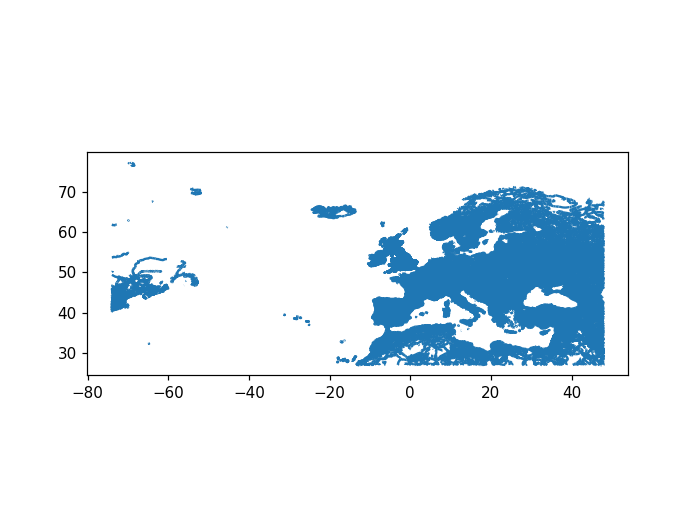

In [4]:
europe_gpd.plot()
plt.show()

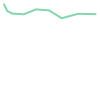

In [5]:
europe_gpd['geometry'][0]

<IPython.core.display.Javascript object>


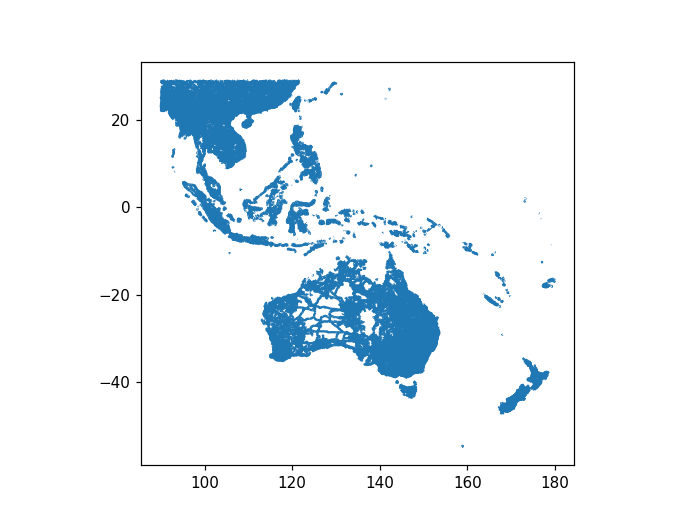

In [12]:
# read the directory with the shapefile data
ocean_df = gpd.read_file("./databases/groads-v1-oceania-east-shp/")
ocean_df.plot()
plt.show()

In [27]:
AUSTRALIA_BOUNDS = [112.0, -39.7, 154.0, -12.3]
AUS_TEST_BOUNDS = [117, -34, 119, -32]
def in_boundary(line):
    # (minx, miny, maxx, maxy)
    b = AUS_TEST_BOUNDS
    lb = line.bounds
    if  lb[0] < b[0] or\
        lb[1] < b[1] or\
        lb[2] > b[2] or\
        lb[3] > b[3]:
        return False
    else:
        return True

australia_df = ocean_df.loc[ocean_df['geometry'].apply(in_boundary)]

<IPython.core.display.Javascript object>


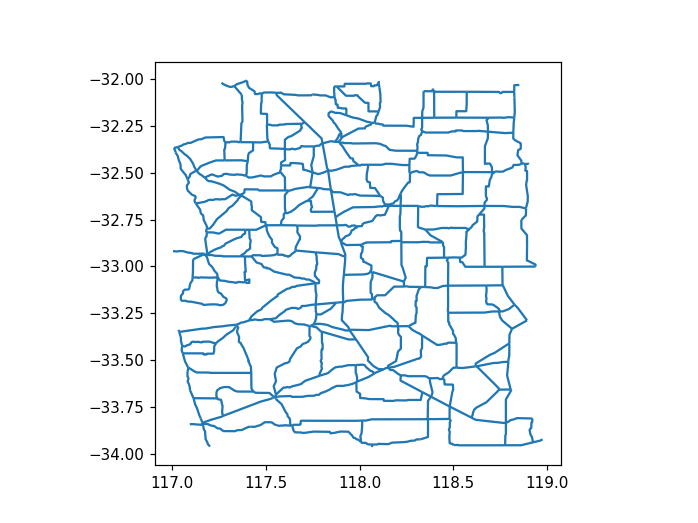

In [31]:
australia_df
australia_df.plot()
plt.show()